### Using OpenCV to load our image 

In [97]:
import cv2

In [98]:
image = cv2.imread('road_pic.jpg')

In [99]:
size = image.shape

In [100]:
print(size)

(704, 1279, 3)


In [101]:
height = image.shape[0]
width = image.shape[1]
channels = image.shape[2]
# 3 channels means its an RGB image, 1 channel means its a BW image
print('height ='+ str(height) + '  '+'width = '+ str(width))

height =704  width = 1279


In [102]:
cv2.imshow('picture', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

![title](road_pic.jpg)

### Converting RGB to BW image for processing

In [103]:
import numpy as np 

In [104]:
lane_image = np.copy(image)
gray = cv2.cvtColor(lane_image, cv2.COLOR_RGB2GRAY)

In [105]:
cv2.imshow('BW image', gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

![title](gray.png)

#### We reduce noise in the image by applying Gaussian Blur function 

In [107]:
# we use 5 by 5 window for guassian blur
blur = cv2.GaussianBlur(gray, [5, 5], 0)

In [108]:
cv2.imshow('GB_image', blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

### We use Canny function to detect edges

In [109]:
# canny function applies a gaussian blur on an image by default
# it detects sharp transitions in pixel values as per given thresholds
# 50 is the lower threshold 
# 150 is the higher threshold

edges = cv2.Canny(blur, 50, 150)

In [110]:
cv2.imshow('canny function', edges)
cv2.waitKey(0)
cv2.destroyAllWindows()

![title](canny.png)

### Detecting our region of interest ROI

In [111]:
# First we use pyplots to visualize the dimensions of our image
import matplotlib.pyplot as plt

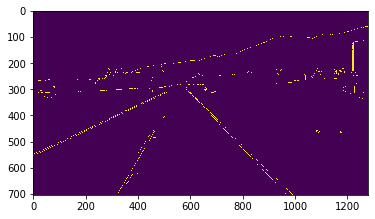

In [112]:
plt.imshow(edges)
plt.show()

#### Our ROI are from coordinates (x= 200, y= height) (x= 1100, y = height) (x= 550, y= 250)
#### This forms a triangle shape which includes the lane in front of the car 

#### We create a mask i.e., array of zeros for the image ( same size as image )

In [113]:
border = np.array([[(200, height), (1100, height), (550, 250)]])

In [114]:
# array of zeros of same size as image
mask = np.zeros_like(gray)

In [115]:
# This function fills our roi with white pixels 
cv2.fillPoly(mask, border, 255)
#(255, 255, 255) specifies white color 

cv2.imshow('ROI Border', mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

![title](mask.png)

### Now the mask is ANDed with our image to obtain the image of our ROI 

In [116]:
# we perform bitwise AND on our edge detedted image with our mask 
# this will give us our ROI

roi = cv2.bitwise_and(edges, mask)

cv2.imshow('ROI Border', roi)
cv2.waitKey(0)
cv2.destroyAllWindows()

![title](roi.png)

In [117]:
print(mask.shape)

(704, 1279)


### Using Hough Transforms to detect lane lines 

In [118]:
lines = cv2.HoughLinesP(roi, 2, np.pi/100, 100, np.array([]), minLineLength=40, maxLineGap=5)

#1st argument is the image we passs as input to the HT
#2nd arg is the rough(p) value or no. of bins, we set it to 2 bins 
#3rd arg is the theta value, we set it to 1 rad
#4th arg is an empty numpy array to contain the values
#5th arg is a built in variable which specifies min no. of pixels for a line to be considered 
#6th arf is a built in variable which specifies max no. of pixel gaps b/w a line 

In [119]:
# To check is our HT function detedted any lines
if lines is not None:
    for line in lines:
        print(line)

[[704 418 927 641]]
[[736 459 844 573]]
[[323 699 452 481]]
[[875 604 952 685]]
[[592 304 704 416]]
[[650 367 704 424]]
[[618 334 781 507]]
[[402 542 453 462]]
[[856 585 903 634]]
[[660 373 754 467]]


#### Each line is a 2D array containing our line coordiantes in the form [ [ x1 y1, x2 y2] ]                              These coordinates specify line parameters as well as the location of the lines with respect to the image space, ensuring that they are placed in the correct position

In [120]:
# We create a black image where we will display our detedted lines
line_image = np.zeros_like(lane_image)

In [121]:
# We have to unpack the line variable which is a 2D array into a 1D array 
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        cv2.line(line_image, (x1,y1), (x2,y2), (255,0,0), 10)
        
#cv2.line() functions draws a line onto the black image i.e., our line_image variable
#x1,y1,x2,y2 are the coordinates where a line must be drawn 
#(255,0,0) specifies line color i.e., Blue here
#5th arg specifies line thickness, here we use 10

In [122]:
cv2.imshow('Lines detected', line_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

![title](lines.png)

In [123]:
#Now displaying lane lines onto the original Image
road_lanes = cv2.addWeighted(lane_image, 0.8, line_image,1, 1)
# I have decreased the pixel intesnities of the lane_image to 0.8
# since the background of line_image is black adding 0s to lane_image wont affect the original image

In [124]:
cv2.imshow('Lanes detected', road_lanes)
cv2.waitKey(0)
cv2.destroyAllWindows()

![title](road_lanes.png)

#### Optimising the detected lines by averaging their slopes and intercepts

In [125]:
for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    line_parameters = np.polyfit((x1,x2), (y1,y2), 1)
    print(line_parameters)

[   1. -286.]
[   1.05555556 -317.88888889]
[  -1.68992248 1244.84496124]
[   1.05194805 -316.45454545]
[   1. -288.]
[   1.05555556 -319.11111111]
[   1.06134969 -321.91411043]
[  -1.56862745 1172.58823529]
[   1.04255319 -307.42553191]
[   1. -287.]


#### first value is the slope and second value is the y-intercept

In [126]:
# Lets average the slope and intercept values of the detected lane lines
left_lane = []
right_lane = []
for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    line_parameters = np.polyfit((x1,x2), (y1,y2), 1)
    slope = line_parameters[0]
    intercept = line_parameters[1]
    if slope < 0:
        left_lane.append((slope, intercept)) #slope of left lane lines is negative
    else:
        right_lane.append((slope, intercept))#slope of right lane lines is positive
    
left_lane_avg = np.average(left_lane, axis=0)
right_lane_avg = np.average(right_lane, axis=0)

print(left_lane_avg)
print(right_lane_avg)

[  -1.62927497 1208.71659827]
[   1.03337026 -305.47427347]


In [127]:
# Lets define a functin which creates coordinates to represnt lane lines in the image
def create_coordinates(image, avg_parameters):
    slope, intercept = avg_parameters
    y1 = height # from bottom of the image
    y2 = int(y1*(3/5)) # to 3/5th of the height of the image
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    return np.array([x1, y1, x2, y2])

In [128]:
left_line = create_coordinates(image, left_lane_avg)
right_line = create_coordinates(image, right_lane_avg)
print(left_line) 
print(right_line)

[309 704 482 422]
[976 704 703 422]


In [129]:
averaged_lines = np.array([(left_line), (right_line)])
print(averaged_lines)

[[309 704 482 422]
 [976 704 703 422]]


In [130]:
line_image_2 = np.zeros_like(lane_image)

for x1, y1, x2, y2 in averaged_lines:
    cv2.line(line_image_2, (x1,y1), (x2,y2), (255,0,0), 10)
        
cv2.imshow('Lines detected', line_image_2)
cv2.waitKey(0)
cv2.destroyAllWindows()

![title](average_lines.png)

In [131]:
#Now displaying lane lines onto the original Image
road_lanes = cv2.addWeighted(lane_image, 0.8, line_image_2,1, 1)

cv2.imshow('combined', road_lanes)
cv2.waitKey(0)
cv2.destroyAllWindows()

![title](combo.png)